# Importing basic packages for processing.

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import folium
from geopy.geocoders import Nominatim
import json
import requests
from pandas.io.json import json_normalize

# Getting the names of the neighbourhoods of Melbourne.

In [2]:
melbourne = pd.read_csv('/Users/Nikhil/Downloads/MelbourneSuburbs.csv')
melbourne_df = pd.DataFrame(columns=['Neighborhood'])
melbourne_df['Neighborhood'] = melbourne.columns
melbourne_df.drop(melbourne_df.tail(1).index,inplace=True)
melbourne_df

,Neighborhood
0,Abbotsford
1,Aberfeldie
2,Airport West
3,Albanvale
4,Albert Park
...,...
405,Wyndham Vale
406,Yallambie
407,Yarrambat
408,Yarraville


# Finding average price of each house in the neighborhoods in Melbourne

In [3]:
melbourne_housing = pd.read_csv('/Users/Nikhil/Downloads/housing.csv')
melbourne_housing = melbourne_housing[['suburb','rooms','price','distance','latitude','longitude']]
melbourne_housing.dropna(inplace=True)

In [4]:
melbourne_housing.rename(columns={'suburb' : 'Neighborhood', 'rooms':'Rooms','price':'Price(2018)','latitude':'Latitude','longitude':'Longitude','distance':'Distance'},inplace=True)
melbourne_housing = melbourne_housing[melbourne_housing['Rooms'] == 2]
melbourne_housing

,Neighborhood,Rooms,Price(2018),Distance,Latitude,Longitude
1,Abbotsford,2,1480000.0,2.5,-37.79960,144.99840
2,Abbotsford,2,1035000.0,2.5,-37.80790,144.99340
10,Abbotsford,2,941000.0,2.5,-37.80410,144.99530
14,Abbotsford,2,1636000.0,2.5,-37.80600,144.99540
18,Abbotsford,2,1097000.0,2.5,-37.80100,144.99890
...,...,...,...,...,...,...
34796,Toorak,2,1025000.0,4.1,-37.84244,145.00816
34841,Williamstown,2,940000.0,6.8,-37.86396,144.90541
34853,Yarraville,2,888000.0,6.3,-37.81551,144.88826
34854,Yarraville,2,705000.0,6.3,-37.82286,144.87856


# Isolating the top 100 expensive neighborhoods in Melbourne.

In [5]:
melbourne_neighborhoods = melbourne_housing[['Neighborhood','Price(2018)']]
melbourne_neighborhoods = melbourne_neighborhoods.groupby(['Neighborhood']).mean().reset_index()
melbourne_neighborhoods.rename(columns={'Price(2018)':'Avg Price(2018)'},inplace=True)
melbourne_neighborhoods.sort_values(by=['Avg Price(2018)'],ascending=False,inplace=True)
melbourne_neighborhoods = melbourne_neighborhoods.head(100)
melbourne_neighborhoods

,Neighborhood,Avg Price(2018)
4,Albert Park,1.543793e+06
85,East Melbourne,1.348500e+06
181,Princes Hill,1.317083e+06
13,Ashburton,1.316429e+06
137,Kooyong,1.290000e+06
...,...,...
62,Clayton,7.530000e+05
87,Elsternwick,7.505200e+05
130,Kensington,7.484793e+05
45,Burwood East,7.460000e+05


# Visualizing Melbourne on a map.

In [6]:
locator = Nominatim(user_agent='d')
location = locator.geocode('Melbourne,Australia')
mel_map = folium.Map(location=[location.latitude,location.longitude],zoom_start = 10)
mel_map

# Visualizing the top 100 neighborhoods.

In [7]:
from opencage.geocoder import OpenCageGeocode
locator = OpenCageGeocode('57df6f0bada648caa17c1ce65c2e7ecb')
latitude = []
longitude = []
for neighborhood in melbourne_neighborhoods['Neighborhood']:
    location = locator.geocode('{},Melbourne,Australia'.format(neighborhood))
    try:
        latitude.append(location[0]['geometry']['lat'])
        longitude.append(location[0]['geometry']['lng'])
    except:
        latitude.append(np.nan)
        longitude.append(np.nan)
for lat,lng in zip(latitude , longitude):
    folium.Marker([lat, lng], popup='<i>Residential Complex</i>').add_to(mel_map)
mel_map

In [8]:
melbourne_neighborhoods['Latitude'] = latitude
melbourne_neighborhoods['Longitude'] = longitude
melbourne_neighborhoods = melbourne_neighborhoods.reset_index()
melbourne_neighborhoods.drop(columns=['index'],inplace=True)
melbourne_neighborhoods

,Neighborhood,Avg Price(2018),Latitude,Longitude
0,Albert Park,1.543793e+06,-37.810400,144.985335
1,East Melbourne,1.348500e+06,-37.812498,144.985885
2,Princes Hill,1.317083e+06,-37.783652,144.961905
3,Ashburton,1.316429e+06,-21.105273,149.088126
4,Kooyong,1.290000e+06,-37.814371,144.989625
...,...,...,...,...
95,Clayton,7.530000e+05,-37.795969,144.939083
96,Elsternwick,7.505200e+05,-37.800410,144.958523
97,Kensington,7.484793e+05,-37.793938,144.930565
98,Burwood East,7.460000e+05,-37.678215,144.862253


# Finding the number of essential services in each neighborhood.

In [9]:
def explorer(names, latitudes, longitudes,radius=1000):
    titleID =["Restaurants",'Arts and Entertainment','Bars','Sports Venues','Medical Centers','Clothing Stores','Grocery Stores','Shopping Malls','Metro Stations']
    catID =['4d4b7105d754a06374d81259','4d4b7104d754a06370d81259','4bf58dd8d48988d116941735','4f4528bc4b90abdf24c9de85','4bf58dd8d48988d104941735','4bf58dd8d48988d103951735','4bf58dd8d48988d118951735','4bf58dd8d48988d1fd941735','4bf58dd8d48988d1fd931735']
    CLIENT_ID = 'D5U52LKULW0C51MXLUBQJFEQYWCVIXGXFHY24CTFMHIUKKJY' 
    CLIENT_SECRET = 'GTG0SVTJGSAGZ3OHK13WCGGKCTB55JDXG2MMMM2BMNEMPQDW'
    VERSION = '20180605'
    temp_df = pd.DataFrame(columns=titleID)
    for title,cat in zip(titleID,catID):
        number= []
        for name, lat, lng in zip(names, latitudes, longitudes):
            venues_list =[]
            url = 'https://api.foursquare.com/v2/venues/search?&categoryId={}&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
                cat,CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION, 
                lat, 
                lng, 
                radius,
                200)
            try:
                results = requests.get(url).json()['response']['venues']
                for v in results:
                    venues_list.append(v['categories'][0]['name'])
                number.append(len(venues_list))
            except IndexError or ValueError:
                print("Error in fetching Data.")
                break
        temp_df[title] = number
    return(temp_df)

In [10]:
defined = explorer(melbourne_neighborhoods['Neighborhood'],melbourne_neighborhoods['Latitude'],melbourne_neighborhoods['Longitude'])

In [11]:
defined

,Restaurants,Arts and Entertainment,Bars,Sports Venues,Medical Centers,Clothing Stores,Grocery Stores,Shopping Malls,Metro Stations
0,50,48,50,44,49,50,17,2,1
1,50,48,50,43,48,49,12,2,1
2,49,36,8,30,20,12,8,1,0
3,0,0,0,0,0,0,0,0,0
4,50,48,46,41,48,49,14,2,0
...,...,...,...,...,...,...,...,...,...
95,50,42,7,24,48,11,7,1,1
96,50,43,49,47,45,47,22,3,0
97,50,32,7,21,16,6,7,1,1
98,14,0,3,2,1,4,0,0,0


# Preparing Dataset for clustering

In [12]:
cols = defined.columns
cluster_dataset = pd.DataFrame(columns=cols)
cluster_dataset['Neighborhood'] = melbourne_neighborhoods['Neighborhood']
cluster_dataset['Price'] = melbourne_neighborhoods['Avg Price(2018)']
for col in defined.columns:
    cluster_dataset[col] = defined[col]
cluster_dataset

,Restaurants,Arts and Entertainment,Bars,Sports Venues,Medical Centers,Clothing Stores,Grocery Stores,Shopping Malls,Metro Stations,Neighborhood,Price
0,50,48,50,44,49,50,17,2,1,Albert Park,1.543793e+06
1,50,48,50,43,48,49,12,2,1,East Melbourne,1.348500e+06
2,49,36,8,30,20,12,8,1,0,Princes Hill,1.317083e+06
3,0,0,0,0,0,0,0,0,0,Ashburton,1.316429e+06
4,50,48,46,41,48,49,14,2,0,Kooyong,1.290000e+06
...,...,...,...,...,...,...,...,...,...,...,...
95,50,42,7,24,48,11,7,1,1,Clayton,7.530000e+05
96,50,43,49,47,45,47,22,3,0,Elsternwick,7.505200e+05
97,50,32,7,21,16,6,7,1,1,Kensington,7.484793e+05
98,14,0,3,2,1,4,0,0,0,Burwood East,7.460000e+05


# Running K-Means Clustering on the Dataset

In [13]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
cluster_dataset.drop(columns=['Neighborhood'],inplace=True)
dataset_fit = StandardScaler().fit_transform(defined)
clusters = 5
krun = KMeans(n_clusters = clusters)
krun.fit(dataset_fit)
generated_labels = krun.labels_
cluster_dataset['Cluster Labels'] = generated_labels
cluster_dataset

,Restaurants,Arts and Entertainment,Bars,Sports Venues,Medical Centers,Clothing Stores,Grocery Stores,Shopping Malls,Metro Stations,Price,Cluster Labels
0,50,48,50,44,49,50,17,2,1,1.543793e+06,0
1,50,48,50,43,48,49,12,2,1,1.348500e+06,0
2,49,36,8,30,20,12,8,1,0,1.317083e+06,3
3,0,0,0,0,0,0,0,0,0,1.316429e+06,1
4,50,48,46,41,48,49,14,2,0,1.290000e+06,0
...,...,...,...,...,...,...,...,...,...,...,...
95,50,42,7,24,48,11,7,1,1,7.530000e+05,3
96,50,43,49,47,45,47,22,3,0,7.505200e+05,0
97,50,32,7,21,16,6,7,1,1,7.484793e+05,3
98,14,0,3,2,1,4,0,0,0,7.460000e+05,1


In [14]:
melbourne_neighborhoods['Cluster Labels'] = cluster_dataset['Cluster Labels']

# Looking at the characteristics of each cluster.

In [15]:
cluster0 = (cluster_dataset[cluster_dataset['Cluster Labels'] == 0]).reset_index()
cluster0.drop(columns=['index'],inplace=True)
cluster0avg = []
for column in cluster0.columns:
    cluster0avg.append(cluster0[column].mean())
cluster0

,Restaurants,Arts and Entertainment,Bars,Sports Venues,Medical Centers,Clothing Stores,Grocery Stores,Shopping Malls,Metro Stations,Price,Cluster Labels
0,50,48,50,44,49,50,17,2,1,1.543793e+06,0
1,50,48,50,43,48,49,12,2,1,1.348500e+06,0
2,50,48,46,41,48,49,14,2,0,1.290000e+06,0
3,50,43,49,47,45,47,22,3,0,1.256364e+06,0
4,50,48,49,46,46,47,34,11,1,1.217643e+06,0
5,50,49,50,48,42,49,21,5,1,1.157741e+06,0
6,50,46,41,48,36,50,16,4,0,1.143548e+06,0
7,50,48,50,46,49,46,17,8,1,1.118630e+06,0
8,50,43,49,47,45,47,22,3,0,1.118000e+06,0
9,50,43,49,47,45,47,22,3,0,1.059000e+06,0


In [16]:
cluster1 = (cluster_dataset[cluster_dataset['Cluster Labels'] == 1]).reset_index()
cluster1.drop(columns=['index'],inplace=True)
cluster1avg = []
for column in cluster1.columns:
    cluster1avg.append(cluster1[column].mean())
cluster1

,Restaurants,Arts and Entertainment,Bars,Sports Venues,Medical Centers,Clothing Stores,Grocery Stores,Shopping Malls,Metro Stations,Price,Cluster Labels
0,0,0,0,0,0,0,0,0,0,1.316429e+06,1
1,0,0,0,0,0,0,0,0,0,1.068375e+06,1
2,22,4,1,4,1,2,0,2,0,9.225500e+05,1
3,0,0,0,0,0,0,0,0,0,9.122692e+05,1
4,0,0,0,0,0,0,0,0,0,9.110294e+05,1
5,3,1,2,0,0,0,1,0,0,8.360372e+05,1
6,2,2,1,1,0,0,0,0,0,8.252727e+05,1
7,0,0,0,0,0,0,0,0,0,7.963125e+05,1
8,19,6,3,6,1,0,2,0,1,7.724583e+05,1
9,16,8,0,8,0,2,0,1,0,7.596212e+05,1


In [17]:
cluster2 = (cluster_dataset[cluster_dataset['Cluster Labels'] == 2]).reset_index()
cluster2.drop(columns=['index'],inplace=True)
cluster2avg = []
for column in cluster2.columns:
    cluster2avg.append(cluster2[column].mean())
cluster2

,Restaurants,Arts and Entertainment,Bars,Sports Venues,Medical Centers,Clothing Stores,Grocery Stores,Shopping Malls,Metro Stations,Price,Cluster Labels
0,50,46,50,48,39,47,36,26,1,1.079878e+06,2
1,50,47,50,47,42,49,46,42,3,1.019887e+06,2
2,50,47,50,47,42,49,46,42,3,1.017803e+06,2
3,50,46,50,45,48,48,36,34,1,8.356389e+05,2
4,50,47,50,47,42,49,45,40,3,8.121667e+05,2
5,50,43,50,46,38,48,40,18,2,7.965118e+05,2


In [18]:
cluster3 = (cluster_dataset[cluster_dataset['Cluster Labels'] == 3]).reset_index()
cluster3.drop(columns=['index'],inplace=True)
cluster3avg = []
for column in cluster3.columns:
    cluster3avg.append(cluster3[column].mean())
cluster3

,Restaurants,Arts and Entertainment,Bars,Sports Venues,Medical Centers,Clothing Stores,Grocery Stores,Shopping Malls,Metro Stations,Price,Cluster Labels
0,49,36,8,30,20,12,8,1,0,1.317083e+06,3
1,49,40,5,26,33,1,1,0,0,1.288200e+06,3
2,50,45,27,35,45,17,9,1,0,1.008212e+06,3
3,50,43,20,31,38,6,5,3,0,9.835000e+05,3
4,50,29,18,43,21,49,4,0,0,9.773053e+05,3
5,50,14,13,24,39,10,3,2,0,9.750000e+05,3
6,50,45,24,37,48,27,9,2,0,9.706071e+05,3
7,50,19,10,12,43,43,2,6,0,9.100000e+05,3
8,50,45,17,39,38,7,7,1,0,9.015556e+05,3
9,50,43,16,45,38,19,10,2,0,8.951391e+05,3


In [19]:
cluster4 = (cluster_dataset[cluster_dataset['Cluster Labels'] == 4]).reset_index()
cluster4.drop(columns=['index'],inplace=True)
cluster4avg = []
for column in cluster4.columns:
    cluster4avg.append(cluster4[column].mean())
cluster4

,Restaurants,Arts and Entertainment,Bars,Sports Venues,Medical Centers,Clothing Stores,Grocery Stores,Shopping Malls,Metro Stations,Price,Cluster Labels
0,31,7,2,11,13,2,1,0,0,1.132000e+06,4
1,43,5,1,19,10,2,0,0,0,1.036250e+06,4
2,43,5,1,19,10,2,0,0,0,9.908750e+05,4
3,28,4,3,3,3,2,3,0,0,9.749559e+05,4
4,28,1,4,10,32,8,1,0,0,9.391251e+05,4
5,35,11,3,5,7,1,0,2,0,8.984000e+05,4
6,28,6,4,2,3,1,0,0,0,8.776500e+05,4
7,50,6,2,12,6,19,2,3,0,8.748462e+05,4
8,47,5,2,18,12,1,8,0,0,8.645568e+05,4
9,44,7,6,20,6,0,3,0,0,8.287143e+05,4


In [20]:
import matplotlib.cm as cm
import matplotlib.colors as colors
x = np.arange(5)
ys = [i + x + (i*x)**2 for i in range(5)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
mel_map2 = folium.Map(location=[-37.840935,144.946457],zoom_start = 10)
markers_colors = []
for lat, lon, poi, cluster in zip(melbourne_neighborhoods['Latitude'], melbourne_neighborhoods['Longitude'],melbourne_neighborhoods['Neighborhood'],melbourne_neighborhoods['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(mel_map2)
mel_map2

# **How is each cluster different from another?**

From finding the average of all the variables in each cluster, we can plot the average below and see how each average varies.

# How does the average number of Restaurants in each cluster vary?

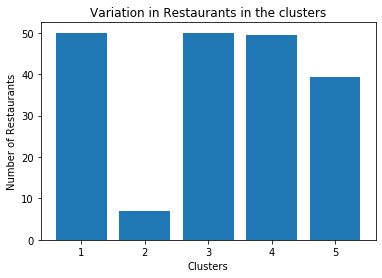

In [21]:
cluster = [1,2,3,4,5]
y = [cluster0avg[0],cluster1avg[0],cluster2avg[0],cluster3avg[0],cluster4avg[0]]
plt.bar(cluster,y)
plt.title("Variation in Restaurants in the clusters")
plt.xlabel('Clusters')
plt.ylabel("Number of Restaurants")
plt.show()

It can be seen from the bar chart above that clusters 1,3,4 and 5 have almost the same number of average restaurants. However, Cluster 2 has a low average number of restaurants.

# How does the average number of Art and Entertainment venues vary?

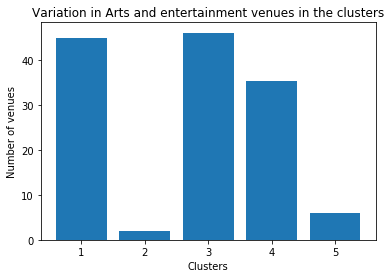

In [33]:
y = [cluster0avg[1],cluster1avg[1],cluster2avg[1],cluster3avg[1],cluster4avg[1]]
plt.bar(cluster,y)
plt.title("Variation in Arts and entertainment venues in the clusters")
plt.xlabel('Clusters')
plt.ylabel("Number of venues")
plt.show()

The plot shows that clusters 1,3 and 4 have a high density of arts and entertainment venues while clusters 2 and 5 have a low number of arts and entertainment venues.

# How does the average number of bars in each cluster vary?

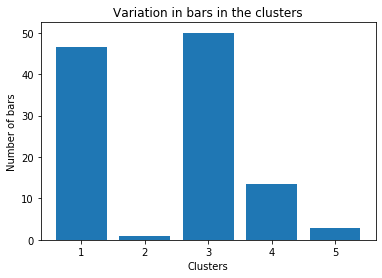

In [23]:
y = [cluster0avg[2],cluster1avg[2],cluster2avg[2],cluster3avg[2],cluster4avg[2]]
plt.bar(cluster,y)
plt.title("Variation in bars in the clusters")
plt.xlabel('Clusters')
plt.ylabel("Number of bars")
plt.show()

Cluster 3 and 4 have a a high density of bars. While clusters 2 and 5 with a lower density of bars. Cluster 1 is almost between clusters 3,4 and 1,5

# How does the average number of Sports venues in each cluster vary?

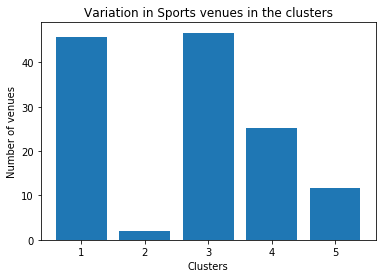

In [24]:
y = [cluster0avg[3],cluster1avg[3],cluster2avg[3],cluster3avg[3],cluster4avg[3]]
plt.bar(cluster,y)
plt.title("Variation in Sports venues in the clusters")
plt.xlabel('Clusters')
plt.ylabel("Number of venues")
plt.show()

The number of sports venues vary similiarly to the number of bars.However cluster 1 has a larger is matched closer to clusters 3 and 4 in the number of sports venues than bars. 

# How does the average number of Medical Centers in each cluster vary?

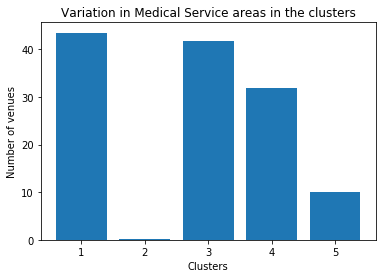

In [25]:
y = [cluster0avg[4],cluster1avg[4],cluster2avg[4],cluster3avg[4],cluster4avg[4]]
plt.bar(cluster,y)
plt.title("Variation in Medical Service areas in the clusters")
plt.xlabel('Clusters')
plt.ylabel("Number of venues")
plt.show()

Clusters 1,3,4 have a high number of medical centers compared to clusters 2 and 5. Cluster 4 has the highest average amount of medical centers followed by cluster 3. 

# How does the average number of clothing stores in each cluster vary?

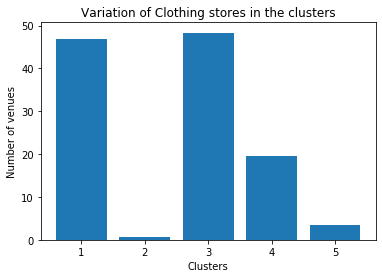

In [26]:
y = [cluster0avg[5],cluster1avg[5],cluster2avg[5],cluster3avg[5],cluster4avg[5]]
plt.bar(cluster,y)
plt.title("Variation of Clothing stores in the clusters")
plt.xlabel('Clusters')
plt.ylabel("Number of venues")
plt.show()

Clusters 3,4 follow the trends as seen previously with a high number, while cluster 2 following the trend of having a low number. Clusters 1 and 5 serve as a balance between Clusters 3,4 and 1,5

# How does the average number of grocery stores in each cluster vary?

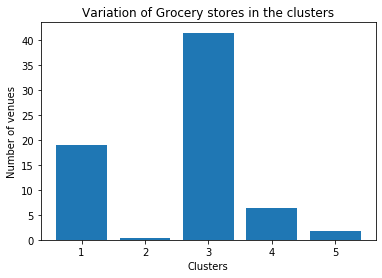

In [27]:
y = [cluster0avg[6],cluster1avg[6],cluster2avg[6],cluster3avg[6],cluster4avg[6]]
plt.bar(cluster,y)
plt.title("Variation of Grocery stores in the clusters")
plt.xlabel('Clusters')
plt.ylabel("Number of venues")
plt.show()

Cluster 3 has the highest number of average grocery stores compared to the other clusters. Cluster 1,5 have a low amount of grocery stores.

# How does the average number of Metro Stations in each cluster vary?

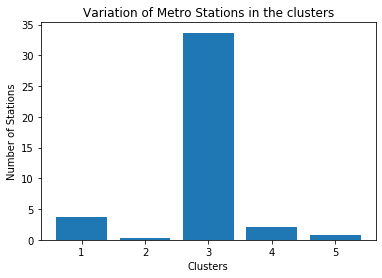

In [28]:
y = [cluster0avg[7],cluster1avg[7],cluster2avg[7],cluster3avg[7],cluster4avg[7]]
plt.bar(cluster,y)
plt.title("Variation of Metro Stations in the clusters")
plt.xlabel('Clusters')
plt.ylabel("Number of Stations")
plt.show()

Cluster 3 has the highest number of metro stations. This suggests the cluster offers great mobility to other parts of Melbourne. However, the other clusters barely have one metro station which can cause difficulties in transportation.

# How does the average number of Shopping Malls in each cluster vary?

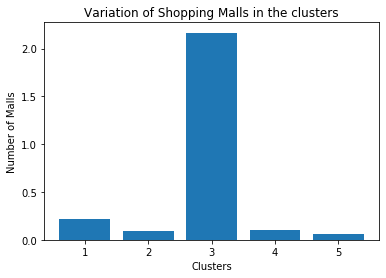

In [29]:
y = [cluster0avg[8],cluster1avg[8],cluster2avg[8],cluster3avg[8],cluster4avg[8]]
plt.bar(cluster,y)
plt.title("Variation of Shopping Malls in the clusters")
plt.xlabel('Clusters')
plt.ylabel("Number of Malls")
plt.show()

Cluster 3 has an very high number of Shopping malls compared to all other clusters. Clusters 1,2,4 and 5 have a very low number of shopping malls.

# How does the average prices of the houses in each cluster vary?

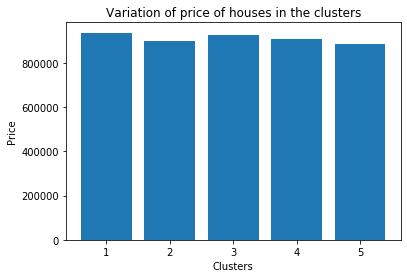

In [30]:
y = [cluster0avg[9],cluster1avg[9],cluster2avg[9],cluster3avg[9],cluster4avg[9]]
plt.bar(cluster,y)
plt.title("Variation of price of houses in the clusters")
plt.xlabel('Clusters')
plt.ylabel("Price")
plt.show()

Suprisingly, all the clusters have similar price for houses. They are evenly matched and have little deviation. We would have expected higher deviations as the average number of essential features for each cluster are not evenly distributed. 